<a href="https://colab.research.google.com/github/shivanijoshi05/speech_emotion_recognition/blob/main/emotion_recognition_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Recognition using CNN

Importing libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from google.colab import drive
import glob
drive.mount('/content/drive')

Mounted at /content/drive


loading dataset

In [7]:
path = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/*.*')
data = pd.read_csv(path[-1])

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-655.344543,86.649872,-12.361262,28.343275,-0.276913,9.111377,-10.830961,-0.023427,-17.030333,-3.272646,...,-5.887830,4.827703,-7.893806,3.420066,-1.663579,-3.320956,-4.437192,-0.790467,-2.032093,neutral
1,-597.755470,68.313810,-5.464898,20.184578,3.788270,3.487281,-7.885428,-4.084610,-14.670673,-5.026546,...,-4.231448,2.109232,-5.899222,0.484595,-1.115013,-4.200195,-4.516998,-1.035014,-2.638597,neutral
2,-724.306396,84.484604,-14.169168,31.050007,-3.062018,9.604833,-14.446255,-0.219572,-20.590328,2.435988,...,-4.019654,3.011943,-8.108849,3.908970,-5.971782,-3.685823,-5.657763,2.423672,-4.886151,neutral
3,-645.409851,87.810638,-17.773392,33.468960,-0.936478,8.191231,-9.919904,-3.311972,-18.590483,-2.199426,...,-6.660094,3.893641,-8.572474,2.928271,-3.344517,-3.604978,-4.101902,-1.308776,-0.581940,neutral
4,-404.925306,23.164804,9.385671,8.897342,4.922053,-0.220186,-2.471936,-5.645275,-7.439860,-4.069184,...,-1.902841,-1.711366,-1.941230,-0.232068,-0.532318,-3.133515,-2.275211,-0.308963,-1.582655,neutral


In [9]:
data['labels'].value_counts()

calm         960
happy        960
sad          960
angry        960
fearful      960
disgust      960
surprised    960
neutral      480
Name: labels, dtype: int64

splitting the data

In [10]:
X = data.iloc[: ,:-1].values
Y = data['labels'].values

In [11]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [13]:
print(X_train.shape)
print(X_test.shape)

(5400, 20)
(1800, 20)


In [14]:
print(y_train.shape)
print(y_test.shape)

(5400, 8)
(1800, 8)


In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5400, 20), (5400, 8), (1800, 20), (1800, 8))

In [16]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5400, 20, 1), (5400, 8), (1800, 20, 1), (1800, 8))

CNN Model Training

In [20]:
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint


model=Sequential()
model.add(Conv1D(256, kernel_size=5, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding = 'same'))


model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 20, 256)           1536      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 10, 256)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 128)           163968    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 128)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 64)            

In [22]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/50
85/85 [==============================] - 5s 59ms/step - loss: 0.5699 - accuracy: 0.8419 - val_loss: 0.8113 - val_accuracy: 0.7628 - lr: 4.0000e-04
Epoch 2/50
85/85 [==============================] - 5s 58ms/step - loss: 0.5577 - accuracy: 0.8520 - val_loss: 0.8174 - val_accuracy: 0.7544 - lr: 4.0000e-04
Epoch 3/50
85/85 [==============================] - 7s 84ms/step - loss: 0.5506 - accuracy: 0.8511 - val_loss: 0.7981 - val_accuracy: 0.7600 - lr: 4.0000e-04
Epoch 4/50
85/85 [==============================] - 8s 100ms/step - loss: 0.5292 - accuracy: 0.8569 - val_loss: 0.8149 - val_accuracy: 0.7639 - lr: 4.0000e-04
Epoch 5/50
85/85 [==============================] - 9s 105ms/step - loss: 0.5309 - accuracy: 0.8578 - val_loss: 0.7986 - val_accuracy: 0.7633 - lr: 4.0000e-04
Epoch 6/50
84/85 [============================>.] - ETA: 0s - loss: 0.5335 - accuracy: 0.8564
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
85/85 [==============================

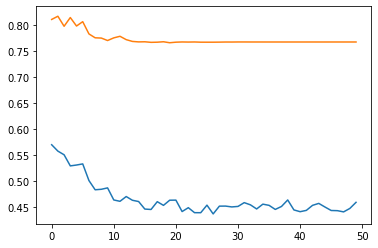

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

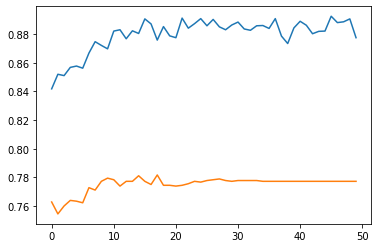

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [25]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [26]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test

df.head(10)

,Predicted Labels,Actual Labels
0,fearful,sad
1,neutral,neutral
2,happy,happy
3,calm,calm
4,calm,calm
5,surprised,surprised
6,angry,angry
7,fearful,fearful
8,calm,fearful
9,angry,angry


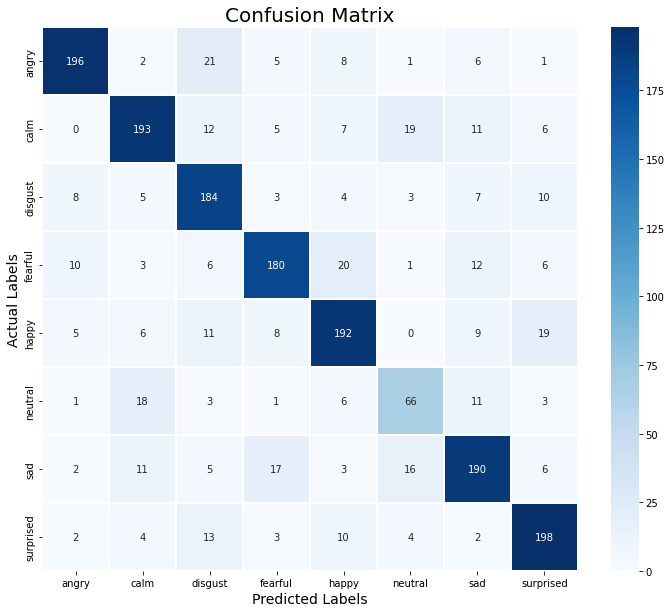

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.88      0.82      0.84       240
        calm       0.80      0.76      0.78       253
     disgust       0.72      0.82      0.77       224
     fearful       0.81      0.76      0.78       238
       happy       0.77      0.77      0.77       250
     neutral       0.60      0.61      0.60       109
         sad       0.77      0.76      0.76       250
   surprised       0.80      0.84      0.82       236

    accuracy                           0.78      1800
   macro avg       0.77      0.77      0.77      1800
weighted avg       0.78      0.78      0.78      1800

